In [215]:
# Standars libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import itertools as it
from collections import Counter
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *

# Utilities functions
import sys
sys.path.append('/home/fanfou/Panorama/notebooks/utils')

print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

from visualization import *
from tools import *

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 199)

# Clustering


Python version
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Version info.
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [209]:
medias = pd.read_csv('/mnt/datastore/data/all_tweets_medias.csv')
medias.head()

,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,url
0,1236718340497907712,807095,nytimes,45370836,898,New York City,205,104,"Schools on both U.S. coasts are starting to close amid fears of the coronavirus, leaving parents to corral their children into online learning sessions and juggle child care https://t.co/KGHFIM95uy",Sun Mar 08 18:20:04 +0000 2020,NaN
1,1236715812263780357,807095,nytimes,45370836,898,New York City,220,107,"A resident of Wilton, Connecticut, became the state’s first coronavirus patient, Gov. Ned Lamont said. The person was most likely infected during a recent trip to California and was hospitalized ...",Sun Mar 08 18:10:01 +0000 2020,NaN
2,1236713308033515522,807095,nytimes,45370836,898,New York City,475,215,"As the number of coronavirus cases in New York state rose to 105, Gov. Andrew Cuomo criticized the U.S. government on Sunday for delays in allowing private laboratories in the state to test for t...",Sun Mar 08 18:00:04 +0000 2020,NaN
3,1236708279549657088,807095,nytimes,45370836,898,New York City,162,60,President Trump hosted President Jair Bolsonaro of Brazil at his Florida estate on Saturday but refused to rule out steel and iron tariffs that have created tension in the relationship between th...,Sun Mar 08 17:40:05 +0000 2020,NaN
4,1236705768801517573,807095,nytimes,45370836,898,New York City,781,507,"Coronavirus updates:\n—Dr. Anthony Fauci, a top U.S. health official, said that a regional lockdown of parts of the U.S. could become necessary\n—He recommended that those at greatest risk — the ...",Sun Mar 08 17:30:06 +0000 2020,NaN


In [214]:
medias.groupby('user_name').count().head(50)

,tweet_id,user_id,followers,friends,user_location,likes,retweets,text,created_at,url
user_name,,,,,,,,,,
20minutesOnline,3128,3128,3128,3128,3128,3128,3128,3128,3128,3067
MailOnline,2051,2051,2051,2051,0,2051,2051,2051,2051,0
USATODAY,2414,2414,2414,2414,2414,2414,2414,2414,2414,1642
guardian,3219,3219,3219,3219,3219,3219,3219,3219,3219,3197
lemondefr,2878,2878,2878,2878,2878,2878,2878,2878,2878,2844
letemps,2946,2946,2946,2946,2946,2946,2946,2946,2946,2904
nytimes,2588,2588,2588,2588,2588,2588,2588,2588,2588,1
washingtonpost,2997,2997,2997,2997,2997,2997,2997,2997,2997,79


# Import  and view all tweets

In [216]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
jsondf = spark.read.json("/mnt/datastore/data/coronavirus/*.json");
jsondf.count()

9365809

In [219]:
jsondf[].head(5)

[Row(author_handle='EvanMcFarlane', geo_location='Greenock, Scotland', lang='en', likes=1, main='I can’t see the shutdown ever happening but it’d be incredible if it did. No league title for Liverpool, Dundee United still stuck in the Championship, Falkirk in League 1. Please. There is no guarantee Liverpool would be crowned Premier League champions if the season was curtailed by coronavirus | @ben_rumsby reports https://www.telegraph.co.uk/football/2020/02/28/no-guarantee-liverpool-would-crowned-premier-league-champions/\xa0…', permalink='https://twitter.com/EvanMcFarlane/status/1233373013040607233', published='2020-02-28T12:46:55Z', replied=False, shared_type='REPLY', shares=1, source_followers=761, source_following=344),
 Row(author_handle='CAREMACHO1', geo_location=None, lang='es', likes=0, main='NO SERÁ Q YA ESTA CONTAGIADO DEL CORONAVIRUS Y NO SE A DADO CUENTA? ACUÉRDESE Q EL VIAJO A CHINA HACE POCO OK?? Aún hay gente que aprueba la gestión de Iván Duque? Pero quienes? Será la ma

In [3]:
jsondf.printSchema()

root
 |-- author_handle: string (nullable = true)
 |-- geo_location: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- likes: long (nullable = true)
 |-- main: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- published: string (nullable = true)
 |-- replied: boolean (nullable = true)
 |-- shared_type: string (nullable = true)
 |-- shares: long (nullable = true)
 |-- source_followers: long (nullable = true)
 |-- source_following: long (nullable = true)



In [4]:
from pyspark.sql import functions as F
groupHour = jsondf.select(F.date_format('published','yyyy-MM-dd hh').alias('date')).groupby("date").count().toPandas()
groupHour['date'] = pd.to_datetime(groupHour['date'])
groupHour = groupHour.sort_values(by=['date'], ascending=True)


No handles with labels found to put in legend.


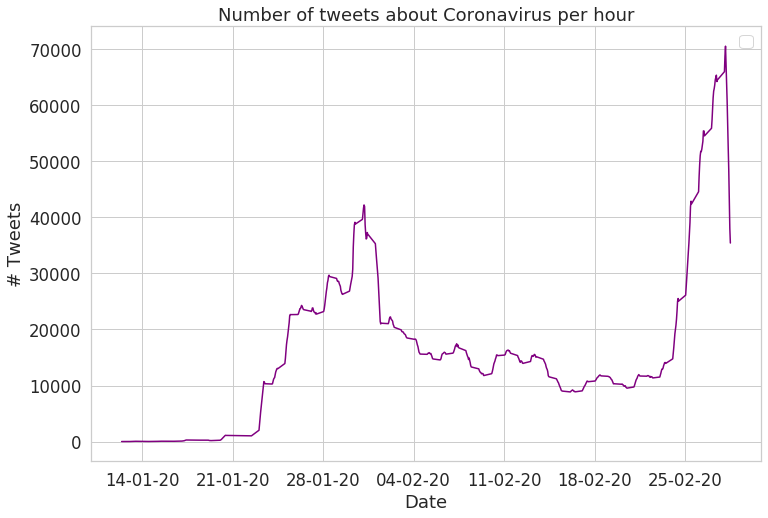

In [5]:
plotTweetPerDay(groupHour[groupHour['date'] > "2020-01-12"], "Number of tweets about Coronavirus per hour", rolling_window=10, col_count="count")

No handles with labels found to put in legend.


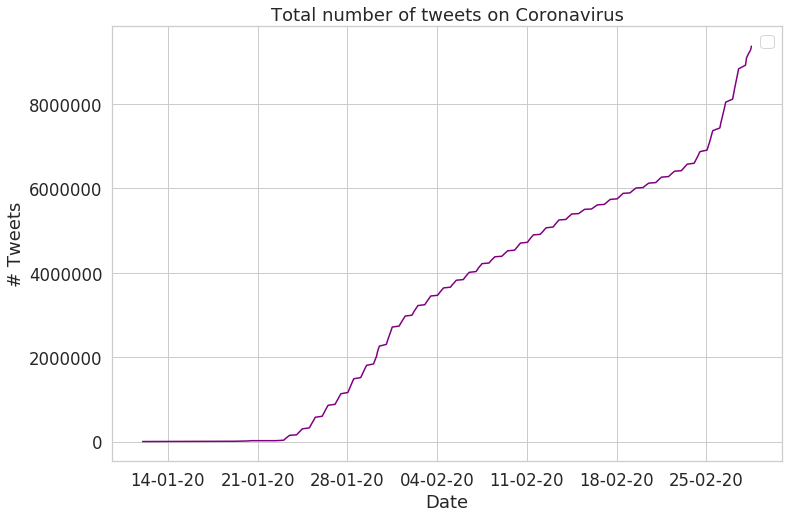

In [6]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

groupHour['cumsum'] = groupHour['count'].cumsum()
df = groupHour[groupHour['date'] > "2020-01-12"]

# Compute rolling mean of the count if needed
y =  df['cumsum'].rolling(window=1).mean()

ax.plot(df['date'],
       y,
        '-o',
        color='purple', marker="")
ax.set(xlabel="Date", ylabel="# Tweets",
       title="Total number of tweets on Coronavirus")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.legend()
plt.show()

## Filter by known medias

In [162]:
RELOAD = False
TWEETS_MEDIAS_PATH = "/mnt/datastore/data/tweets_medias.csv"

if RELOAD:
    medias_accounts = pd.read_csv("/mnt/datastore/data/top_twitter_medias.csv", header=None)
    tweets_medias = jsondf.filter(col("author_handle").isin(medias_accounts[0].values.tolist())).toPandas()
    tweets_medias['published'] = pd.to_datetime(tweets_medias['published'], infer_datetime_format=True)
    tweets_medias.to_csv(TWEETS_MEDIAS_PATH, encoding='utf-8', index=False)
else :
    tweets_medias = pd.read_csv(TWEETS_MEDIAS_PATH)
    tweets_medias['published'] = pd.to_datetime(tweets_medias['published'], infer_datetime_format=True) 

tweets_medias.count()

author_handle       77883
geo_location        45181
lang                77883
likes               77881
main                77883
permalink           77883
published           77883
replied             77883
shared_type         77883
shares              77881
source_followers    77883
source_following    77883
dtype: int64

### Dataset Summary

In [8]:
tweets_medias.head()

,author_handle,geo_location,lang,likes,main,permalink,published,replied,shared_type,shares,source_followers,source_following
0,MyNews13,"Orlando, FL",en,0.0,What’s the biggest way to keep a virus away? Health officials Agree it’s washing your hands. There’s a right way to do it! @ybruzual demonstrates. #Covid_19 coverage: https://www.mynews13.com/fl/...,https://twitter.com/MyNews13/status/1233127388764086273,2020-02-27 20:30:54,False,REPLY,0.0,258797,2063
1,radionz,NaN,en,3.0,"""Coronavirus is a global health crisis, with confirmed cases of the virus in over 25 countries where people are not banned from travelling to New Zealand. ""Covid-19 cannot simply be attributed to...",https://twitter.com/radionz/status/1233103771040792578,2020-02-27 18:57:03,False,REPLY,1.0,44730,331
2,vdare,NaN,en,2.0,"It's becoming increasingly clear calling Trump a ""racist"" is a higher priority to Democrats than actual protecting the American people. #Coronavirus #CoronaOutbreak It's time -- #ImmigrationMorat...",https://twitter.com/vdare/status/1233063539839033345,2020-02-27 16:17:11,False,REPLY,0.0,43383,4177
3,varunkrish,NaN,en,0.0,Thank the heavens for MWC being cancelled. Such a huge spike in new infections around the world especially in Europe Coronavirus in Spain: Spain reports first locally transmitted case. “The virus...,https://twitter.com/varunkrish/status/1233123449385570304,2020-02-27 20:15:15,False,REPLY,0.0,23596,3485
4,tokyoreporter,NaN,en,2.0,Dentsu employee tests positive for coronavirus 【速報】大手広告代理店の「電通」は、東京・港区の電通本社ビルに勤務する５０代の男性従業員１人が新型コロナウイルスの感染検査で「陽性」であることが確認されたと発表しました。あすから本社ビルに勤務する全従業員について、在宅勤務に切り替えるということです。 #新型コロナウイルス #新型肺炎 pic.t...,https://twitter.com/tokyoreporter/status/1232253431089266688,2020-02-25 10:38:06,False,REPLY,3.0,49825,982


### Volume of tweets

No handles with labels found to put in legend.


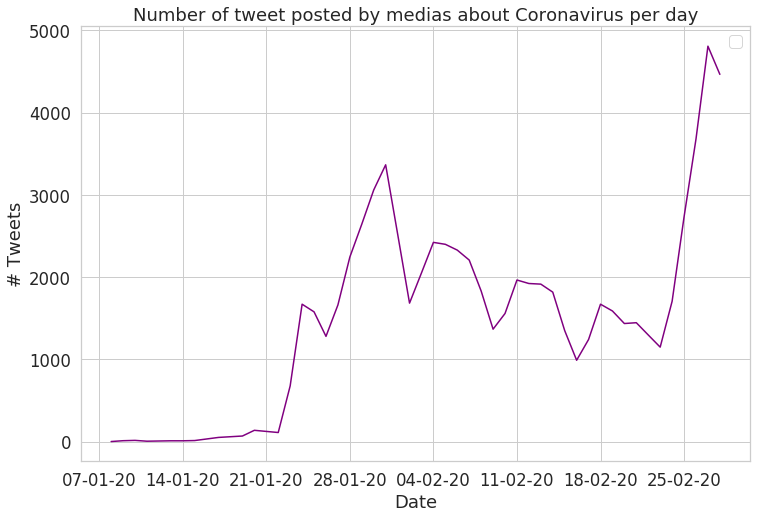

In [9]:
tweets_medias_count = countByDay(tweets_medias, "published")
title = "Number of tweet posted by medias about Coronavirus per day"
plotTweetPerDay(tweets_medias_count, title, rolling_window=2)

## Putting everything together

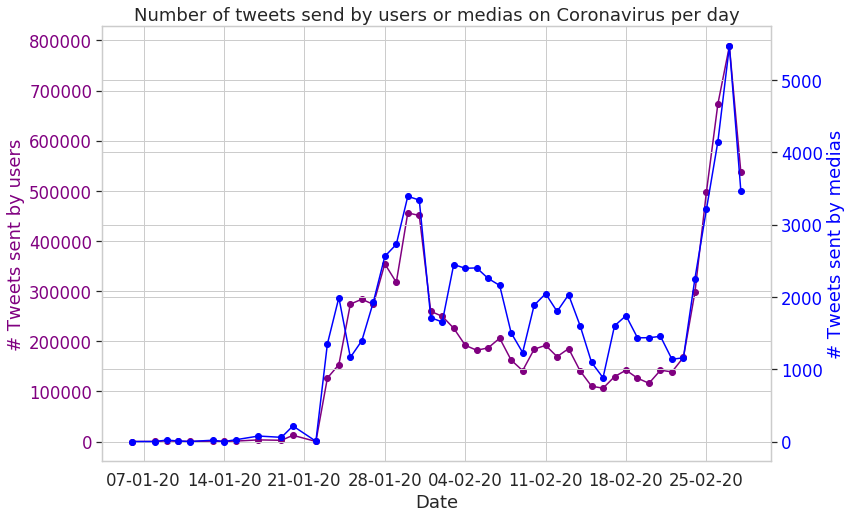

In [10]:
tweets_per_day = groupHour.groupby([groupHour.date.dt.year, groupHour.date.dt.month, groupHour.date.dt.day])['count'].sum()
tweets_per_day.index.names = ['Year', 'Month','Day']
tweets_per_day = tweets_per_day.reset_index()
tweets_per_day['date'] = pd.to_datetime(tweets_per_day[['Year', 'Month', 'Day']])
tweets_per_day = tweets_per_day[['date', 'count']]

merge = tweets_medias_count.merge(tweets_per_day, left_on='date', right_on='date', how='inner').fillna(0)
plotTweetPerDay2Axis(merge, "count", "published", "date", y_1_label="# Tweets sent by users", y_2_label="# Tweets sent by medias")


## Tweets reactions

Get All tweets with actual number of retweets, likes and url of the article if there is one

In [11]:
# Save the list of tweets ids to use them with the twitter api
with open('/mnt/datastore/data/media_tweets_ids.txt', 'wb') as f:
    pickle.dump(tweets_medias.permalink.str.split("/").str[-1].values, f)

In [12]:
medias_with_reactions = pd.read_csv("/mnt/datastore/data/tweets_medias_full.csv")
medias_with_reactions['created_at'] = pd.to_datetime(medias_with_reactions['created_at'], infer_datetime_format=True)
medias_with_reactions = medias_with_reactions.sort_values(by=['retweets'], ascending=False)
medias_with_reactions.head(5)

/home/fanfou/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,url
31168,1231977743237160963,7996082,el_pais,7289967.0,761.0,Madrid,12633.0,12515.0,ÚLTIMA HORA | La OMS pide al mundo que se prepare para una “potencial pandemia” por el coronavirus\nhttps://t.co/uHAj02vW5x https://t.co/81M6dL908v,2020-02-24 16:22:37+00:00,NaN
810,1232669578339196928,18643437,PrisonPlanet,1106984.0,703.0,London,30367.0,11253.0,"Russia, which closed its border with China in the early days of the outbreak, reported just two coronavirus cases (both Chinese citizens who have now recovered).\n\nIn comparison, Italy, which im...",2020-02-26 14:11:44+00:00,NaN
21707,1232358387142287362,807095,nytimes,45309248.0,898.0,New York City,11946.0,8611.0,Breaking News: The CDC warned Americans to begin preparing for the possibility of a coronavirus outbreak: “This might be bad.”\nhttps://t.co/shDMqT9TAz,2020-02-25 17:35:10+00:00,NaN
57297,1230215431220318208,21366823,allkpop,5455865.0,615.0,Worldwide,25779.0,8553.0,"B.I revealed to have donated 10,000 facemasks anonymously to Chinese fans amidst Coronavirus outbreak https://t.co/t25yFUNXt7 https://t.co/zRMzlb6gF1",2020-02-19 19:39:49+00:00,https://www.allkpop.com/article/2020/02/bi-revealed-to-have-donated-10000-facemasks-anonymously-to-chinese-fans-amidst-coronavirus-outbreak
1886,1233134710638825473,146569971,CDCgov,1473106.0,267.0,"Atlanta, GA",7308.0,7992.0,"CDC does not currently recommend the use of facemasks to help prevent novel #coronavirus. Take everyday preventive actions, like staying home when you are sick and washing hands with soap and wat...",2020-02-27 21:00:00+00:00,NaN


In [13]:
medias_with_reactions.count()

tweet_id         77083
user_id          77083
user_name        77080
followers        77080
friends          77080
user_location    71408
likes            77080
retweets         77080
text             77080
created_at       77077
url              40775
dtype: int64

> Top retweets by media

In [14]:
medias_with_reactions[['retweets', 'user_name']].groupby('user_name').sum().sort_values(by=['retweets'], ascending=False).head(10)

,retweets
user_name,
nytimes,130721.0
business,122341.0
WHO,98646.0
PrisonPlanet,73947.0
el_pais,52982.0
RT_com,51546.0
washingtonpost,49683.0
cnnbrk,44545.0
allkpop,42335.0


> Top likes by media

In [15]:
medias_with_reactions[['likes', 'user_name']].groupby('user_name').sum().sort_values(by=['likes'], ascending=False).head(10)

,likes
user_name,
PrisonPlanet,235117.0
nytimes,220909.0
allkpop,191458.0
business,160320.0
ANI,154165.0
WHO,128317.0
cnnbrk,79653.0
SpeakerPelosi,79076.0
RT_com,78770.0


> Compute the ratio, number of retweets by number of followers and tweets

In [16]:
medias_with_reactions['ratio_retweet'] = (medias_with_reactions['retweets'])/(medias_with_reactions['followers']+1)

medias_with_reactions[['ratio_retweet', 'user_name']].groupby('user_name').sum().sort_values(by=['ratio_retweet'], ascending=False).head(10)

,ratio_retweet
user_name,
SecretNews,0.628557
TheKoreaHerald,0.158181
TheLastRefuge2,0.153264
RichardViguerie,0.102041
TheNewDailyAu,0.077180
bactiman63,0.076092
PrisonPlanet,0.066793
RadioFreeAsia,0.051866
RawStory,0.044801


In [17]:
(medias_with_reactions[['ratio_retweet', 'user_name']].groupby('user_name').sum() / medias_with_reactions[['ratio_retweet', 'user_name']].groupby('user_name').count()).sort_values(by=['ratio_retweet'], ascending=False).head(10)

,ratio_retweet
user_name,
RichardViguerie,0.010204
dougthompson,0.008547
bbj_hu,0.003454
AURNOnline,0.003361
TheLastRefuge2,0.003065
RadioFreeAsia,0.003051
InvestingDaily,0.002669
montrosepress,0.002556
palisadeshudson,0.002123


## Events analysis

In [18]:
tweets_medias_full = pd.read_csv("/mnt/datastore/data/tweets_medias_full.csv")
tweets_medias_full.loc[47860]['text']

/home/fanfou/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


'Why coronavirus in China could help save the pangolin and other endangered species https://t.co/lw8dVBWc5D https://t.co/h0hqGgiv2J'

In [19]:
#tweets_medias_full.sort_values(by=['created_at'], ascending=True)[tweets_medias_full["created_at"]>"2020-01-19"][tweets_medias_full["retweets"] > 100].head(100)

tweets_medias_full.sort_values(by=['created_at'], ascending=True)[tweets_medias_full["user_name"] =="WHO"].head(10)
                                                                  
                                                                  

/home/fanfou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,url
867,1228250100742393856,14499829,WHO,5581982.0,1716.0,"Geneva, Switzerland",26.0,9.0,"@UN @DrTedros @WHOAFRO @OMSRDCONGO @Presidence_RDC ""And we must also prepare for other crises, such as the current outbreak of #COVID19""-@DrTedros #DRC \n\nhttps://t.co/YCoQtKqY8P",Fri Feb 14 09:30:18 +0000 2020,NaN
76,1228251291803099137,14499829,WHO,5581935.0,1716.0,"Geneva, Switzerland",26.0,12.0,"@UN @DrTedros @WHOAFRO @OMSRDCONGO @Presidence_RDC ""We are most concerned about communities and countries, that have weaker health systems, which in turn may be more vulnerable to the import of t...",Fri Feb 14 09:35:02 +0000 2020,NaN
868,1228251603230130177,14499829,WHO,5581983.0,1716.0,"Geneva, Switzerland",30.0,15.0,"@UN @DrTedros @WHOAFRO @OMSRDCONGO @Presidence_RDC ""Therefore, we are focusing our efforts on strengthening diagnostic capacities &amp; delivering supplies like masks, gloves and aprons to protec...",Fri Feb 14 09:36:16 +0000 2020,NaN
14678,1228285146756939790,14499829,WHO,5586591.0,1716.0,"Geneva, Switzerland",383.0,261.0,"On Thursday 14’840 cases, including 13’332 clinically diagnosed #COVID19 cases were reported from Hubei, #China.\nThis is the first time 🇨🇳 has reported clinically diagnosed cases in addition to ...",Fri Feb 14 11:49:34 +0000 2020,NaN
6326,1228292101433106432,14499829,WHO,5584206.0,1716.0,"Geneva, Switzerland",82.0,31.0,"@WHOWPRO @WHOSEARO @WHO_Europe @pahowho @WHOAFRO @WHOEMRO For consistency, we report in the #COVID19 WHO Situation Report only the number of laboratory-confirmed cases https://t.co/CuHzkYU5us\n\n...",Fri Feb 14 12:17:12 +0000 2020,NaN
4071,1228316069871464452,14499829,WHO,5583378.0,1716.0,"Geneva, Switzerland",63.0,33.0,"@WHOWPRO @WHOSEARO @WHO_Europe @pahowho @WHOAFRO @WHOEMRO WHO has formally requested additional information on the #COVID19 clinically diagnosed cases, in particular when these have occurred in t...",Fri Feb 14 13:52:26 +0000 2020,NaN
69588,1228334921401323520,14499829,WHO,5596406.0,1716.0,"Geneva, Switzerland",742.0,500.0,Daily media briefing on #COVID19 with @DrTedros. #coronavirus https://t.co/gjUCjZjJ4N,Fri Feb 14 15:07:21 +0000 2020,NaN
13523,1228443207383605249,14499829,WHO,5586312.0,1716.0,"Geneva, Switzerland",483.0,285.0,"In view of the urgency of the #COVID19 outbreak, the international community is sharing knowledge and mobilizing to accelerate the development of interventions, incl. vaccines and therapeutics.\n...",Fri Feb 14 22:17:38 +0000 2020,NaN
18513,1230872193510318086,14499829,WHO,5587515.0,1716.0,"Geneva, Switzerland",83.0,71.0,"@DrTedros ""As of 6am GVA time this morning, #China has reported a total of 75,567 cases of #COVID19 to WHO, including 2,239 deaths.\n\nIn the past 24 hours, 🇨🇳 has reported 892 new confirmed case...",Fri Feb 21 15:09:34 +0000 2020,NaN
1652,1230872433969844227,14499829,WHO,5582364.0,1716.0,"Geneva, Switzerland",62.0,35.0,"@DrTedros ""This may indicate because the health system in Wuhan, 🇨🇳 have regained the ability to test all suspected #COVID19 cases.\n\nAs a result, some cases that had been clinically confirmed h...",Fri Feb 21 15:10:31 +0000 2020,NaN


/home/fanfou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


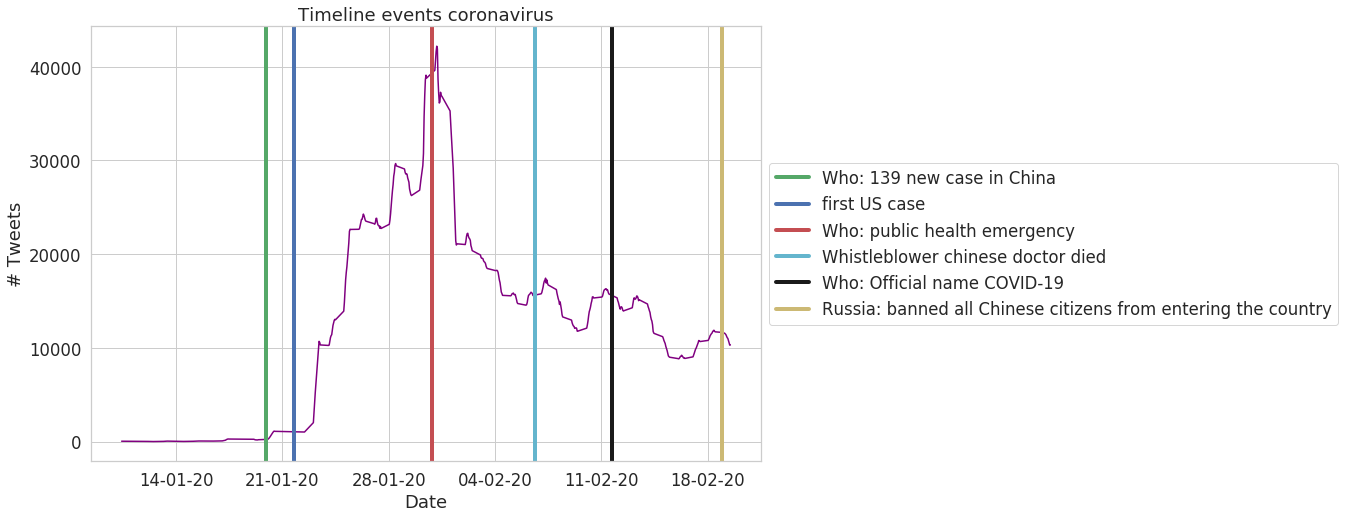

In [31]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
df = groupHour[groupHour['date'] > "2020-01-10"][groupHour['date'] < "2020-02-20"]
# Compute rolling mean of the count if needed
y =  df['count'].rolling(window=10).mean()

ax.plot(df['date'],
       y,
        '-o',
        color='purple', marker="")
ax.set(xlabel="Date", ylabel="# Tweets",
       title="Timeline events coronavirus")

# Plot the vertical line if needed

plt.axvline(linewidth=4, color='g', x=pd.Timestamp("2020-01-19 22:39:07"), label="Who: 139 new case in China")
#plt.axvline(linewidth=4, color='b', x=pd.Timestamp("2020-01-20 17:54:10"), label="Who: Emergency Committee")
plt.axvline(linewidth=4, color='b', x=pd.Timestamp("2020-01-21 18:37:41+00:00"), label="first US case")

plt.axvline(linewidth=4, color='r', x=pd.Timestamp("2020-01-30 19:45:15"), label="Who: public health emergency")
plt.axvline(linewidth=4, color='c', x=pd.Timestamp("2020-02-06 15:46:26"), label="Whistleblower chinese doctor died")
plt.axvline(linewidth=4, color='k', x=pd.Timestamp("2020-02-11 17:20:08"), label="Who: Official name COVID-19")
plt.axvline(linewidth=4, color='y', x=pd.Timestamp("2020-02-18 22:45:37"), label="Russia: banned all Chinese citizens from entering the country")


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))


# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



#plt.legend()
plt.show()

## Closer look on OMS tweets

No handles with labels found to put in legend.


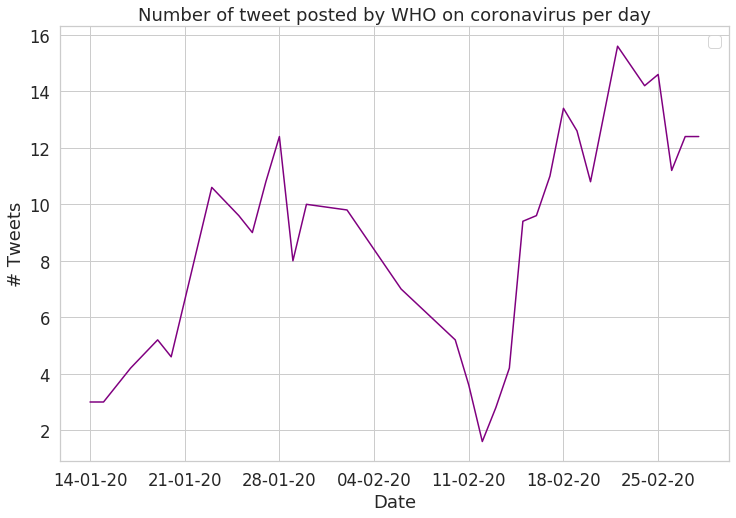

In [32]:
count_oms = countByDay(medias_with_reactions[medias_with_reactions['user_name'] == "WHO"], "created_at")
plotTweetPerDay(count_oms, "Number of tweet posted by WHO on coronavirus per day", 5, col_count="created_at")

# Tweets keywords analysis

> Preprocess tweets, lower, remove urls, etc...

In [77]:
dataset = pd.read_csv("/mnt/datastore/data/tweets_medias_full.csv")
dataset = medias_with_reactions[~medias_with_reactions.text.isna()]
dataset['created_at'] = pd.to_datetime(medias_with_reactions['created_at'])
stop_words = pd.read_csv('/mnt/datastore/data/stopwords.csv', header=None).values.flatten()

def computeTopWords(df, stopwords=None):
    # Lowercase
    df['text'] = df['text'].str.lower()

    # Remove links 
    df['text'] = df['text'].apply(remove_url)

    # Tokenize
    df['text'] = df['text'].str.split(" ")

    # Get flatten list of words
    all_words = list(it.chain(*df.text.values))

    # remove stop words 
    if stopwords is not None:
        all_words = [w for w in all_words if not w in stop_words]
    
    all_words = [w for w in all_words if not w in ['coronavirus']]
    # Create counter
    counts = Counter(all_words)

    return pd.DataFrame(counts.most_common(200),
                                 columns=['words', 'count'])


In [37]:
all_top = computeTopWords(dataset, stopwords=stop_words)
all_top.head(10)

,words,count
0,china,15171
1,outbreak,10100
2,new,7677
3,health,7623
4,cases,6870
5,us,6536
6,wuhan,6057
7,case,4636
8,people,4292
9,confirmed,4271


In [64]:
beforeSpike =  computeTopWords(dataset[dataset['created_at'] <= "2020-02-18"], stopwords=stop_words)
afterSpike = computeTopWords(dataset[dataset['created_at'] > "2020-01-18"], stopwords=stop_words)


/home/fanfou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/fanfou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/fanfou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [65]:
beforeSpike['ratio'] = beforeSpike['count']/beforeSpike['count'].sum()
afterSpike['ratio'] = afterSpike['count']/afterSpike['count'].sum()


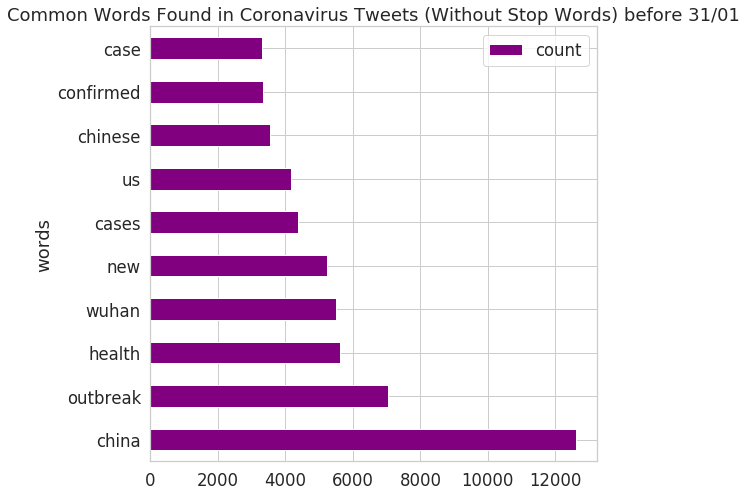

In [66]:
beforeSpike_top = beforeSpike.sort_values(by=['ratio'], ascending=False).head(10)
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
beforeSpike_top.plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Coronavirus Tweets (Without Stop Words) before 31/01")

plt.show()

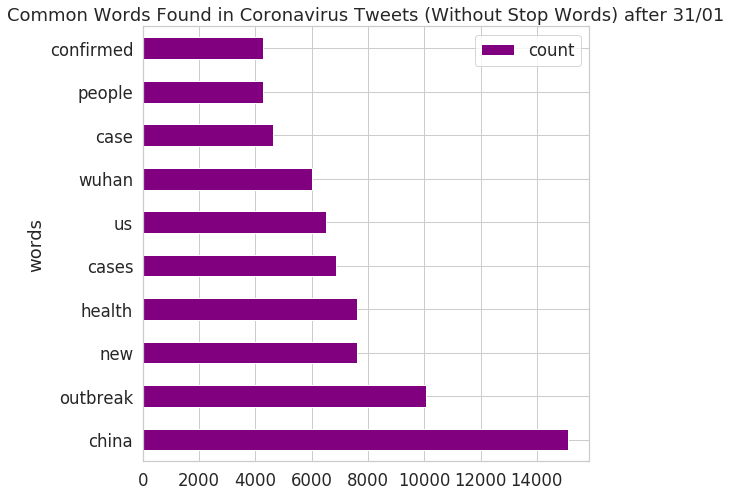

In [67]:
afterSpike_top = afterSpike.sort_values(by=['ratio'], ascending=False).head(10)
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
afterSpike_top.plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Coronavirus Tweets (Without Stop Words) after 31/01")

plt.show()

In [68]:
mergeDiff = beforeSpike.merge(afterSpike, left_on='words', right_on='words', how='inner')
mergeDiff['diff'] = (mergeDiff['ratio_x']-mergeDiff['ratio_y']).abs()
mergeDiff = mergeDiff.rename(columns={"ratio_x": "ratioBefore", "ratio_y": "ratioAfter"})
test = mergeDiff.sort_values(by=['diff'], ascending=False)
test.head()

,words,count_x,ratioBefore,count_y,ratioAfter,diff
0,china,12597,0.058922,15100,0.048581,0.010341
3,wuhan,5485,0.025656,6012,0.019342,0.006314
71,covid19,808,0.003779,2801,0.009012,0.005232
7,chinese,3554,0.016624,4234,0.013622,0.003002
176,south,410,0.001918,1505,0.004842,0.002924


In [71]:
test.sort_values(by=['diff'], ascending=False).head(20)

,words,count_x,ratioBefore,count_y,ratioAfter,diff
0,china,12597,0.058922,15100,0.048581,0.010341
3,wuhan,5485,0.025656,6012,0.019342,0.006314
71,covid19,808,0.003779,2801,0.009012,0.005232
7,chinese,3554,0.016624,4234,0.013622,0.003002
176,south,410,0.001918,1505,0.004842,0.002924
28,fears,1560,0.007297,2913,0.009372,0.002075
14,death,2595,0.012138,3166,0.010186,0.001952
8,confirmed,3331,0.015581,4262,0.013712,0.001869
2,health,5627,0.026320,7605,0.024467,0.001853
15,spread,2516,0.011769,4159,0.013381,0.001612


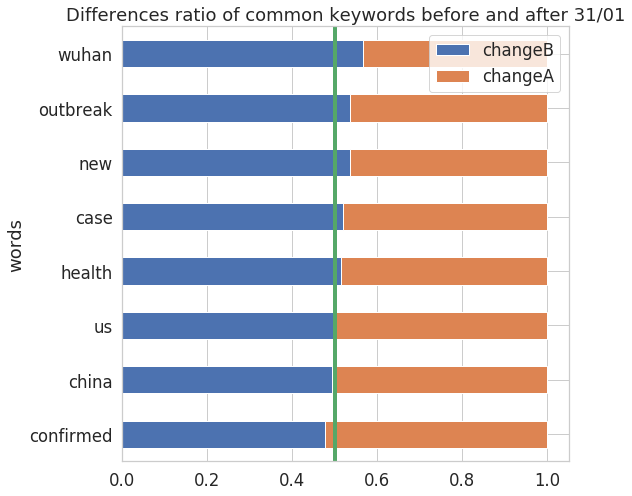

In [47]:
test['changeB'] = test['ratioBefore']/(test['ratioBefore'] + test['ratioAfter'])
test['changeA'] = test['ratioAfter']/(test['ratioBefore'] + test['ratioAfter'])
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
test.sort_values(by=['changeB'], ascending=True).plot.barh(x='words',
                      y=['changeB', 'changeA'],
                      ax=ax,
                       stacked=True,
                      )

ax.set_title("Differences ratio of common keywords before and after 31/01")
plt.axvline(linewidth=4, color='g', x=0.5)

plt.show()

## Tweets clustering

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN

k = 6
dataset = pd.read_csv("/mnt/datastore/data/tweets_medias_full.csv")
dataset = dataset[~dataset.text.isna()]

vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
X = vectorizer.fit_transform(dataset.text.values)

km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1,
                verbose=False)
km.fit(X)

print("Top terms per cluster:")

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()

for i in range(k):
    print ("Cluster %d:" % i,end="")
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind],end="")
    print()

/home/fanfou/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Top terms per cluster:
Cluster 0: death toll china rises cases 000 outside new reports reported
Cluster 1: china outbreak health new chinese fears says amid global travel
Cluster 2: cruise ship japan quarantined passengers positive princess diamond tested aboard
Cluster 3: spread people china health new virus officials infected outbreak killed
Cluster 4: wuhan china virus outbreak city chinese new hospital hit died
Cluster 5: case cases confirmed new health confirms officials reported china california


In [88]:
dataset = pd.read_csv("/mnt/datastore/data/tweets_medias_full.csv")
dataset['created_at'] = pd.to_datetime(dataset['created_at'])
dataset = dataset[~dataset.text.isna()]

# Lowercase
dataset['text'] = dataset['text'].str.lower()

# Remove links 
dataset['text'] = dataset['text'].apply(remove_url)

# Tokenize
#dataset['text'] = df['text'].str.split(" ")

princess_diamond = ['cruise','princess', 'diamond']
china = ['wuhan', 'china', 'chinese']
oms = ['health',  'emergency',  'officials',  'public',  'declares',  'world',  'organization',  'global',  'department']
first_case = ['first', 'second', 'new', 'case', 'cases']
europe = ['pandemic']#['france', 'italy', 'germany', 'switzerland', 'spain', 'europe', 'milan']

princess_diamond_count = dataset[dataset.text.str.contains('|'.join(princess_diamond))]
china_count = dataset[dataset.text.str.contains('|'.join(china))]
oms_count = dataset[dataset.text.str.contains('|'.join(oms))]
first_case_count = dataset[dataset.text.str.contains('|'.join(first_case))]
europe_count = dataset[dataset.text.str.contains('|'.join(europe))]

princess_diamond_count = countByDay(princess_diamond_count, "created_at")
china_count = countByDay(china_count, "created_at")
oms_count = countByDay(oms_count, "created_at")
first_case_count = countByDay(first_case_count, "created_at")
europe_count = countByDay(europe_count, "created_at")


/home/fanfou/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


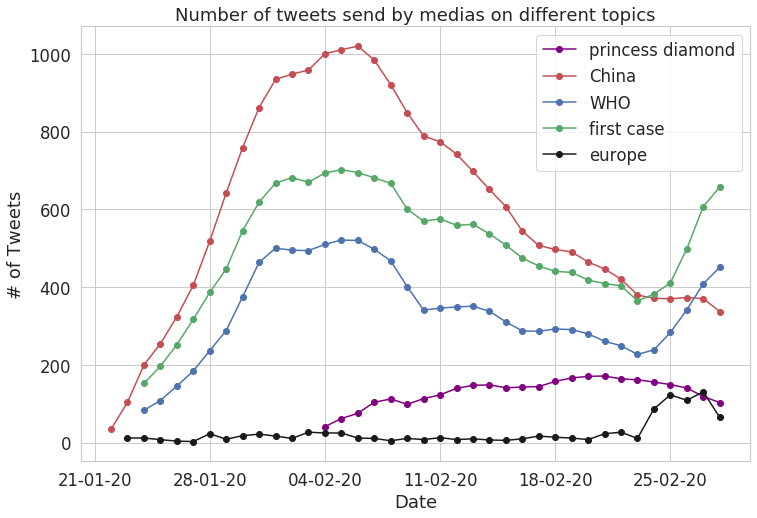

In [89]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(princess_diamond_count['date'],
        princess_diamond_count['created_at'].rolling(window=10).mean(),
        '-o',
        color='purple', label="princess diamond")

ax.plot(china_count['date'],
        china_count['created_at'].rolling(window=10).mean(),
        '-o',
        color='r', label="China")

ax.plot(oms_count['date'],
        oms_count['created_at'].rolling(window=10).mean(),
        '-o',
        color='b', label="WHO")

ax.plot(first_case_count['date'],
        first_case_count['created_at'].rolling(window=10).mean(),
        '-o',
        color='g', label="first case")

ax.plot(europe_count['date'],
        europe_count['created_at'].rolling(window=1).mean(),
        '-o',
        color='k', label="europe")

ax.set_ylabel('# of Tweets')
ax.set(xlabel="Date",
       title="Number of tweets send by medias on different topics")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.legend()
plt.show()

## Country analysis

In [96]:
dataset = pd.read_csv("/mnt/datastore/data/tweets_medias_full.csv")
dataset = dataset[~dataset.text.isna()]
locations = dataset.drop_duplicates(subset ="user_location")[['user_location']]
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm
tqdm.pandas()

geolocator = Nominatim(user_agent="sdd")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
locations['location'] = locations['user_location'].progress_apply(geocode)
locations.head(200)
locations = locations[~locations['user_location'].isna()]
locations = locations[locations['user_location'].str.lower() != "worldwide"]
locations = locations[locations['user_location'].str.lower() != "global"]
locations = locations[locations['user_location'].str.lower() != "studio 1a"]
locations = locations[locations['user_location'].str.lower() != "36000 ft"]
locations = locations[locations['user_location'].str.lower() != "Everywhere"]
locations = locations[~locations['location'].isna()]








  0%|          | 0/1498 [00:00<?, ?it/s]





  0%|          | 3/1498 [00:01<08:45,  2.85it/s]





  0%|          | 4/1498 [00:02<13:48,  1.80it/s]





  0%|          | 5/1498 [00:03<18:28,  1.35it/s]





  0%|          | 6/1498 [00:04<20:55,  1.19it/s]





  0%|          | 7/1498 [00:05<22:15,  1.12it/s]





  1%|          | 8/1498 [00:06<23:10,  1.07it/s]





  1%|          | 9/1498 [00:07<23:52,  1.04it/s]





  1%|          | 10/1498 [00:08<24:20,  1.02it/s]





  1%|          | 11/1498 [00:09<24:38,  1.01it/s]





  1%|          | 12/1498 [00:10<24:56,  1.01s/it]





  1%|          | 13/1498 [00:11<25:03,  1.01s/it]





  1%|          | 14/1498 [00:12<25:07,  1.02s/it]





  1%|          | 15/1498 [00:13<25:11,  1.02s/it]





  1%|          | 16/1498 [00:14<25:45,  1.04s/it]





  1%|          | 17/1498 [00:15<25:42,  1.04s/it]





  1%|          | 18/1498 [00:16<25:35,  1.04s/it]





  1%|▏         | 19/1498 [00:17<25:38,  1.04s/it]





  1%|▏         | 20/

 15%|█▍        | 224/1498 [03:52<21:53,  1.03s/it]





 15%|█▌        | 225/1498 [03:53<21:55,  1.03s/it]





 15%|█▌        | 226/1498 [03:54<21:52,  1.03s/it]





 15%|█▌        | 227/1498 [03:55<21:48,  1.03s/it]





 15%|█▌        | 228/1498 [03:56<21:53,  1.03s/it]





 15%|█▌        | 229/1498 [03:57<21:53,  1.04s/it]





 15%|█▌        | 230/1498 [03:58<21:52,  1.04s/it]





 15%|█▌        | 231/1498 [03:59<21:47,  1.03s/it]





 15%|█▌        | 232/1498 [04:00<21:43,  1.03s/it]





 16%|█▌        | 233/1498 [04:02<21:39,  1.03s/it]





 16%|█▌        | 234/1498 [04:03<21:38,  1.03s/it]





 16%|█▌        | 235/1498 [04:04<21:37,  1.03s/it]





 16%|█▌        | 236/1498 [04:05<21:35,  1.03s/it]





 16%|█▌        | 237/1498 [04:06<22:01,  1.05s/it]





 16%|█▌        | 238/1498 [04:07<21:55,  1.04s/it]





 16%|█▌        | 239/1498 [04:08<21:45,  1.04s/it]





 16%|█▌        | 240/1498 [04:09<21:48,  1.04s/it]





 16%|█▌        | 241/1498 [04:10<21:45,  1.04s/i

 30%|██▉       | 444/1498 [07:41<18:04,  1.03s/it]





 30%|██▉       | 445/1498 [07:42<18:04,  1.03s/it]





 30%|██▉       | 446/1498 [07:43<18:02,  1.03s/it]





 30%|██▉       | 447/1498 [07:44<18:00,  1.03s/it]





 30%|██▉       | 448/1498 [07:45<17:58,  1.03s/it]





 30%|██▉       | 449/1498 [07:46<17:57,  1.03s/it]





 30%|███       | 450/1498 [07:47<17:58,  1.03s/it]





 30%|███       | 451/1498 [07:48<18:05,  1.04s/it]





 30%|███       | 452/1498 [07:49<18:01,  1.03s/it]





 30%|███       | 453/1498 [07:50<17:57,  1.03s/it]





 30%|███       | 454/1498 [07:52<17:56,  1.03s/it]





 30%|███       | 455/1498 [07:53<18:12,  1.05s/it]





 30%|███       | 456/1498 [07:54<18:07,  1.04s/it]





 31%|███       | 457/1498 [07:55<18:01,  1.04s/it]





 31%|███       | 458/1498 [07:56<17:57,  1.04s/it]





 31%|███       | 459/1498 [07:57<18:01,  1.04s/it]





 31%|███       | 460/1498 [07:58<18:02,  1.04s/it]





 31%|███       | 461/1498 [07:59<17:58,  1.04s/i

 44%|████▍     | 664/1498 [11:31<14:13,  1.02s/it]





 44%|████▍     | 665/1498 [11:32<14:12,  1.02s/it]





 44%|████▍     | 666/1498 [11:33<14:13,  1.03s/it]





 45%|████▍     | 667/1498 [11:34<14:16,  1.03s/it]





 45%|████▍     | 668/1498 [11:35<14:18,  1.03s/it]





 45%|████▍     | 669/1498 [11:36<14:13,  1.03s/it]





 45%|████▍     | 670/1498 [11:37<14:11,  1.03s/it]





 45%|████▍     | 671/1498 [11:38<14:10,  1.03s/it]





 45%|████▍     | 672/1498 [11:39<14:10,  1.03s/it]





 45%|████▍     | 673/1498 [11:40<14:07,  1.03s/it]





 45%|████▍     | 674/1498 [11:41<14:05,  1.03s/it]





 45%|████▌     | 675/1498 [11:42<14:21,  1.05s/it]





 45%|████▌     | 676/1498 [11:43<14:15,  1.04s/it]





 45%|████▌     | 677/1498 [11:44<14:14,  1.04s/it]





 45%|████▌     | 678/1498 [11:45<14:08,  1.04s/it]





 45%|████▌     | 679/1498 [11:46<14:05,  1.03s/it]





 45%|████▌     | 680/1498 [11:47<14:01,  1.03s/it]





 45%|████▌     | 681/1498 [11:48<14:29,  1.06s/i

 59%|█████▉    | 884/1498 [15:19<10:37,  1.04s/it]





 59%|█████▉    | 885/1498 [15:20<10:35,  1.04s/it]





 59%|█████▉    | 886/1498 [15:21<10:33,  1.03s/it]





 59%|█████▉    | 887/1498 [15:22<10:31,  1.03s/it]





 59%|█████▉    | 888/1498 [15:23<10:28,  1.03s/it]





 59%|█████▉    | 889/1498 [15:24<10:27,  1.03s/it]





 59%|█████▉    | 890/1498 [15:25<10:26,  1.03s/it]





 59%|█████▉    | 891/1498 [15:26<10:24,  1.03s/it]





 60%|█████▉    | 892/1498 [15:27<10:23,  1.03s/it]





 60%|█████▉    | 893/1498 [15:28<10:22,  1.03s/it]





 60%|█████▉    | 894/1498 [15:29<10:28,  1.04s/it]





 60%|█████▉    | 895/1498 [15:30<10:25,  1.04s/it]





 60%|█████▉    | 896/1498 [15:31<10:47,  1.08s/it]





 60%|█████▉    | 897/1498 [15:32<10:37,  1.06s/it]





 60%|█████▉    | 898/1498 [15:33<10:32,  1.05s/it]





 60%|██████    | 899/1498 [15:34<10:26,  1.05s/it]





 60%|██████    | 900/1498 [15:35<10:30,  1.05s/it]





 60%|██████    | 901/1498 [15:36<10:24,  1.05s/i

 74%|███████▎  | 1103/1498 [19:07<06:46,  1.03s/it]





 74%|███████▎  | 1104/1498 [19:08<06:44,  1.03s/it]





 74%|███████▍  | 1105/1498 [19:09<06:46,  1.03s/it]





 74%|███████▍  | 1106/1498 [19:10<06:44,  1.03s/it]





 74%|███████▍  | 1107/1498 [19:11<06:43,  1.03s/it]





 74%|███████▍  | 1108/1498 [19:12<06:49,  1.05s/it]





 74%|███████▍  | 1109/1498 [19:13<06:49,  1.05s/it]





 74%|███████▍  | 1110/1498 [19:14<06:46,  1.05s/it]





 74%|███████▍  | 1111/1498 [19:15<06:42,  1.04s/it]





 74%|███████▍  | 1112/1498 [19:16<06:40,  1.04s/it]





 74%|███████▍  | 1113/1498 [19:17<06:41,  1.04s/it]





 74%|███████▍  | 1114/1498 [19:18<06:39,  1.04s/it]





 74%|███████▍  | 1115/1498 [19:19<06:36,  1.04s/it]





 74%|███████▍  | 1116/1498 [19:20<06:34,  1.03s/it]





 75%|███████▍  | 1117/1498 [19:21<06:32,  1.03s/it]





 75%|███████▍  | 1118/1498 [19:22<06:30,  1.03s/it]





 75%|███████▍  | 1119/1498 [19:23<06:29,  1.03s/it]





 75%|███████▍  | 1120/1498 [19:

 88%|████████▊ | 1321/1498 [22:55<03:02,  1.03s/it]





 88%|████████▊ | 1322/1498 [22:56<03:01,  1.03s/it]





 88%|████████▊ | 1323/1498 [22:57<03:00,  1.03s/it]





 88%|████████▊ | 1324/1498 [22:58<02:59,  1.03s/it]





 88%|████████▊ | 1325/1498 [22:59<02:58,  1.03s/it]





 89%|████████▊ | 1326/1498 [23:00<02:56,  1.03s/it]





 89%|████████▊ | 1327/1498 [23:01<02:55,  1.03s/it]





 89%|████████▊ | 1328/1498 [23:02<02:57,  1.04s/it]





 89%|████████▊ | 1329/1498 [23:03<02:55,  1.04s/it]





 89%|████████▉ | 1330/1498 [23:04<02:56,  1.05s/it]





 89%|████████▉ | 1331/1498 [23:05<02:54,  1.04s/it]





 89%|████████▉ | 1332/1498 [23:06<02:52,  1.04s/it]





 89%|████████▉ | 1333/1498 [23:07<02:50,  1.04s/it]





 89%|████████▉ | 1334/1498 [23:08<02:49,  1.03s/it]





 89%|████████▉ | 1335/1498 [23:09<02:47,  1.03s/it]





 89%|████████▉ | 1336/1498 [23:10<02:46,  1.03s/it]





 89%|████████▉ | 1337/1498 [23:11<02:45,  1.03s/it]





 89%|████████▉ | 1338/1498 [23:

In [125]:
dataset = pd.read_csv("/mnt/datastore/data/tweets_medias_full.csv")
dataset = dataset[~dataset.text.isna()]
dataset = dataset.merge(locations, left_on='user_location', right_on='user_location', how='left')
dataset['created_at'] = pd.to_datetime(dataset['created_at'])
dataset.to_csv("/mnt/datastore/data/tweets_medias_full.csv", encoding='utf-8', index=False)

/home/fanfou/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


tweet_id         77080
user_id          77080
user_name        77080
followers        77080
friends          77080
user_location    71408
likes            77080
retweets         77080
text             77080
created_at       77077
url              40775
location         68141
dtype: int64

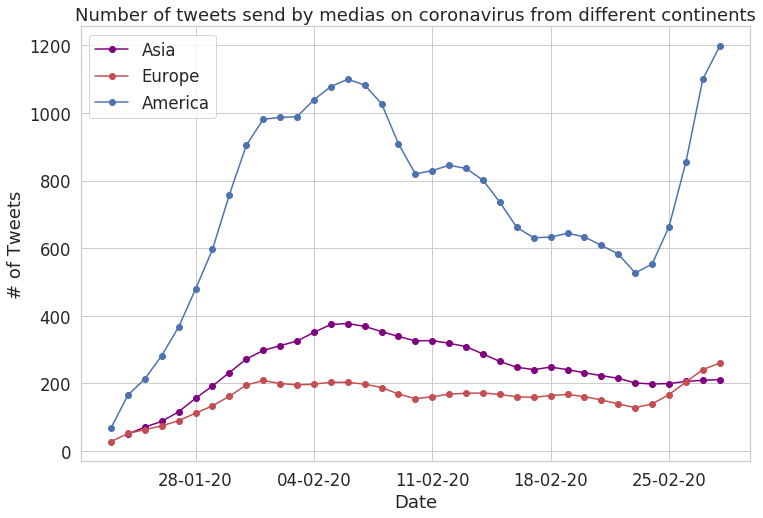

In [201]:
dataset['country'] = dataset['location'].apply(lambda loc: loc.address.split(", ")[-1] if not pd.isnull(loc) else None)

america = ['United States of America', 'Canada']
europe = ['United Kingdom', 'Switzerland', 'Ireland', 'France', 'España', 'Deutschland']
asia = ['Philippines', 'China', 'Malaysia', 'Indonesia', 'India']

asia_count = countByDay(dataset[dataset['country'].isin(asia)], "created_at")
europe_count = countByDay(dataset[dataset['country'].isin(europe)], "created_at")
america_count = countByDay(dataset[dataset['country'].isin(america)], "created_at")


# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(asia_count['date'],
        asia_count['created_at'].rolling(window=10).mean(),
        '-o',
        color='purple', label="Asia")

ax.plot(europe_count['date'],
        europe_count['created_at'].rolling(window=10).mean(),
        '-o',
        color='r', label="Europe")

ax.plot(america_count['date'],
        america_count['created_at'].rolling(window=10).mean(),
        '-o',
        color='b', label="America")

ax.set_ylabel('# of Tweets')
ax.set(xlabel="Date",
       title="Number of tweets send by medias on coronavirus from different continents")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.legend()
plt.show()



In [200]:
dataset.groupby("country").count()

,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,url,location
country,,,,,,,,,,,,
Afghanistan,133,133,133,133,133,133,133,133,133,133,11,133
Africa,220,220,220,220,220,220,220,220,220,220,219,220
Argentina,20,20,20,20,20,20,20,20,20,20,13,20
Armenia,19,19,19,19,19,19,19,19,19,19,15,19
Asia,26,26,26,26,26,26,26,26,26,26,1,26
Australia,1959,1959,1959,1959,1959,1959,1959,1959,1959,1959,865,1959
Azerbaijan,48,48,48,48,48,48,48,48,48,48,0,48
Azərbaycan,34,34,34,34,34,34,34,34,34,34,34,34
Bahamas,7,7,7,7,7,7,7,7,7,7,0,7


## Tweets vs virus spread

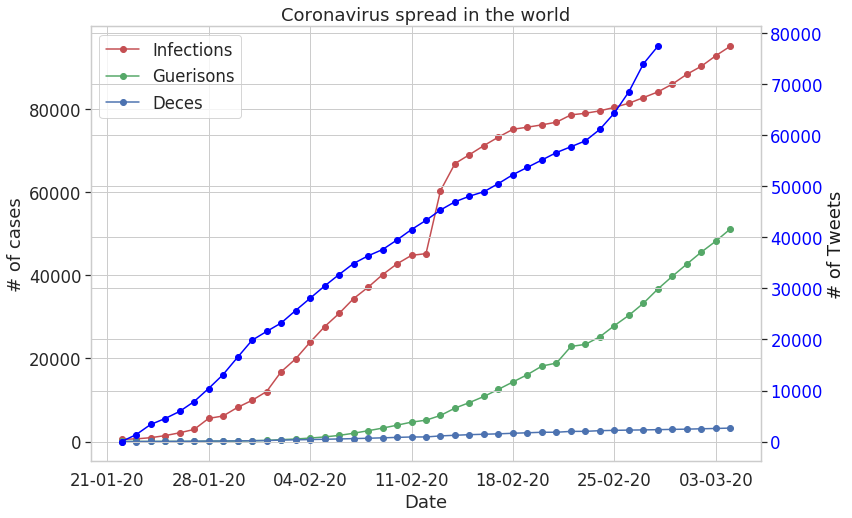

In [178]:
coronavirus = pd.read_csv("/mnt/datastore/data/coronavirus_2020-03-05.csv", sep=";")
coronavirus['date'] = pd.to_datetime(coronavirus['Date'])
coronavirus_count = coronavirus.groupby([coronavirus.date.dt.year, coronavirus.date.dt.month, coronavirus.date.dt.day])[['Infections', 'Guerisons', 'Deces']].sum()
coronavirus_count.index.names = ['Year', 'Month','Day']
coronavirus_count = coronavirus_count.reset_index()
coronavirus_count['date'] = pd.to_datetime(coronavirus_count[['Year', 'Month', 'Day']])
coronavirus_count = coronavirus_count[['date', 'Infections', 'Guerisons', 'Deces']]

tweets_medias_count = countByDay(tweets_medias, "published")
tweets_medias_count = tweets_medias_count[tweets_medias_count['date'].isin(coronavirus_count['date'])]

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(coronavirus_count['date'],
        coronavirus_count['Infections'].rolling(window=1).mean(),
        '-o',
        color='r', label="Infections")

ax.plot(coronavirus_count['date'],
        coronavirus_count['Guerisons'].rolling(window=1).mean(),
        '-o',
        color='g', label="Guerisons")

ax.plot(coronavirus_count['date'],
        coronavirus_count['Deces'].rolling(window=1).mean(),
        '-o',
        color='b', label="Deces")

ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in the world")
plt.legend()
ax2 = ax.twinx()
ax2.plot(tweets_medias_count['date'],
    tweets_medias_count['published'].cumsum(),
    '-o',
    color='blue', label="users")
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='blue')
    
# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()